In [2]:
import os
import psycopg
import pandas as pd

TABLE_NAME = 'flats_clean_table'

os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

EDA process

In [3]:
df.isna().sum()

id                   0
building_id          0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

In [4]:
df.dtypes

id                     int64
building_id            int64
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment          object
studio                object
total_area           float64
price                float64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator          object
dtype: object

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['category'] = kbd.fit_transform(df[['price']])

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

ASSETS_DIR = "assets"

sns.set_style("white")
sns.set_theme(style="whitegrid") 

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

os.makedirs(ASSETS_DIR, exist_ok=True)

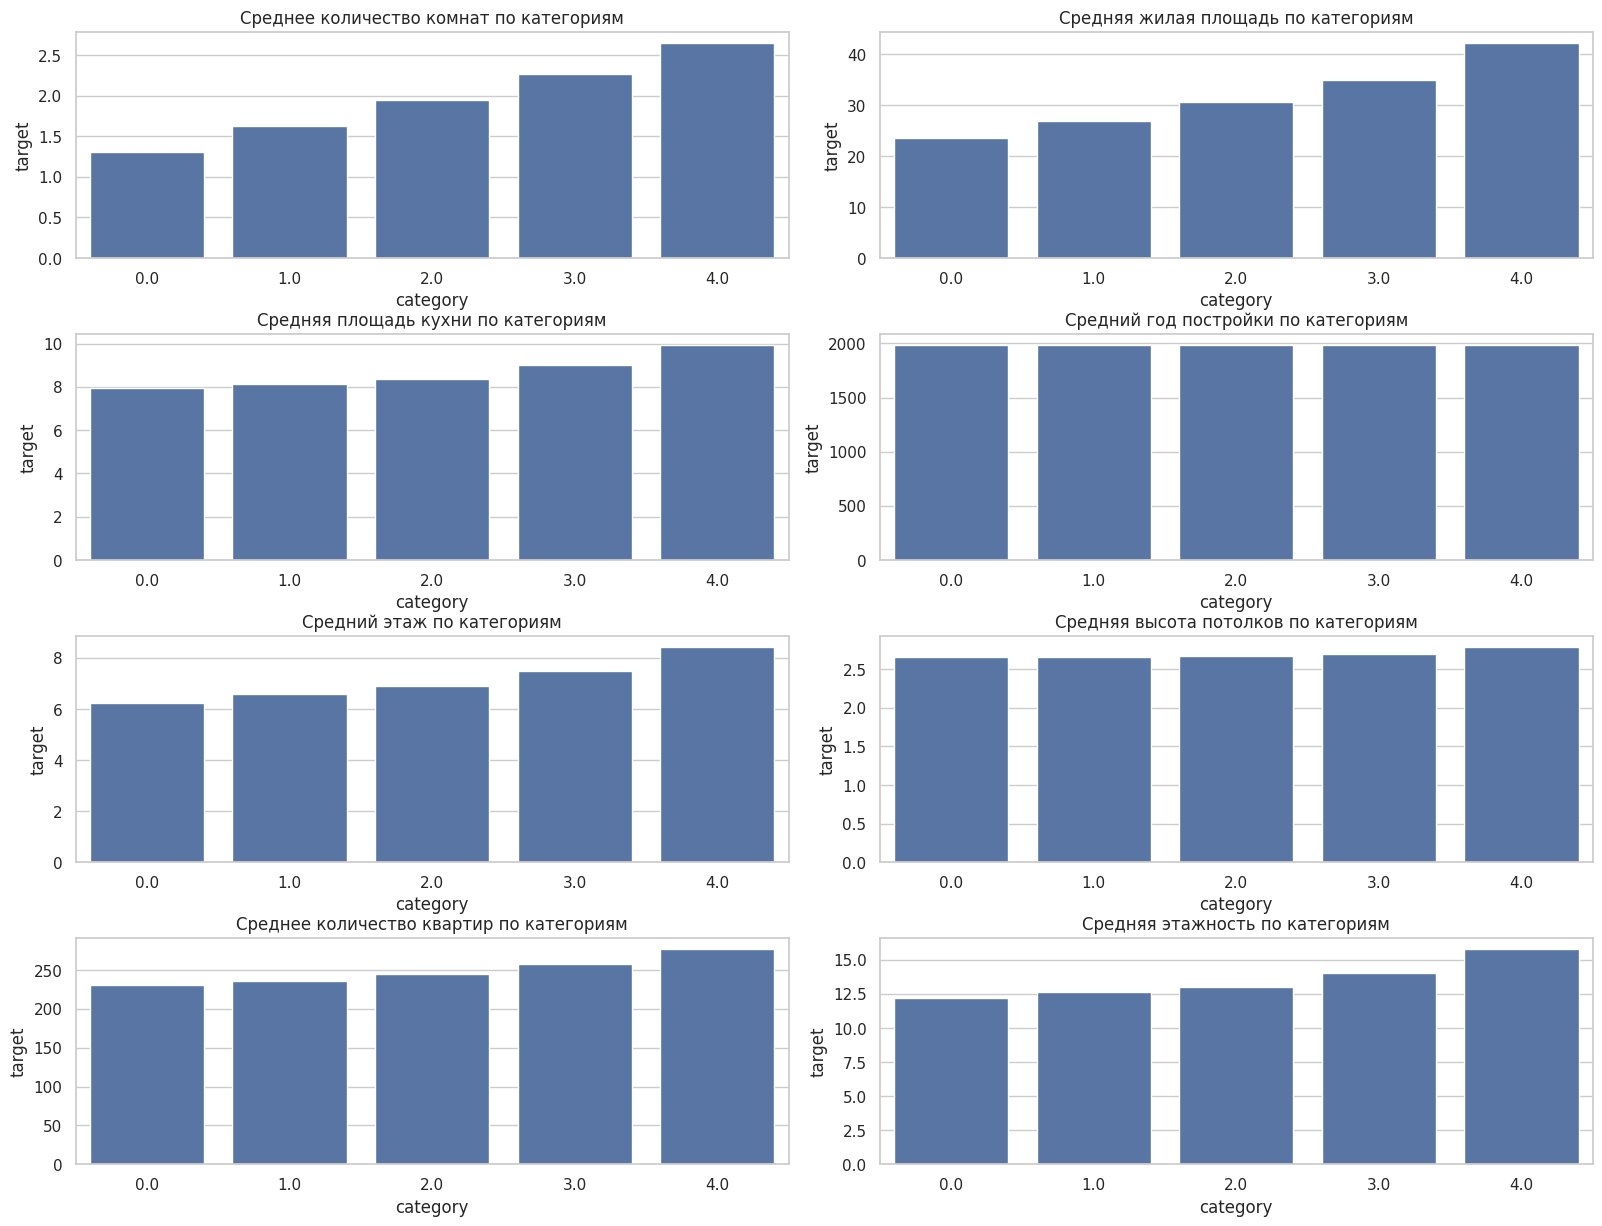

In [7]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=2.5)

x = "category"
y = "rooms"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[0, 0])
axs[0, 0].set_title('Среднее количество комнат по категориям')

y = "living_area"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[0, 1])
axs[0, 1].set_title('Средняя жилая площадь по категориям')

y = "kitchen_area"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[1, 0])
axs[1, 0].set_title('Средняя площадь кухни по категориям')

y = "build_year"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[1, 1])
axs[1, 1].set_title('Средний год постройки по категориям')

y = "floor"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[2, 0])
axs[2, 0].set_title('Средний этаж по категориям')

y = "ceiling_height"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[2, 1])
axs[2, 1].set_title('Средняя высота потолков по категориям')

y = "flats_count"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[3, 0])
axs[3, 0].set_title('Среднее количество квартир по категориям')

y = "floors_total"
stat = ["mean"]
agg_df = df.groupby(x).agg({y:stat}).reset_index()
agg_df['target'] = agg_df[agg_df.columns[1]]
sns.barplot(data=agg_df, x=x, y='target', ax=axs[3, 1])
axs[3, 1].set_title('Средняя этажность по категориям')

plt.savefig(os.path.join(ASSETS_DIR,'influence_on_target'))


In [8]:
x = "category"
binary_columns = [
    "is_apartment", 
    "studio", 
    "has_elevator"
]

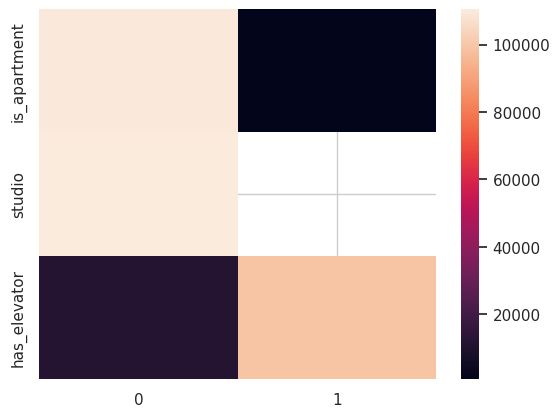

In [9]:
heat_df = df[binary_columns].apply(lambda col: col.apply(lambda x: 1 if x == 'true' else 0))
heat_df = heat_df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR,'heat_map_binary'))


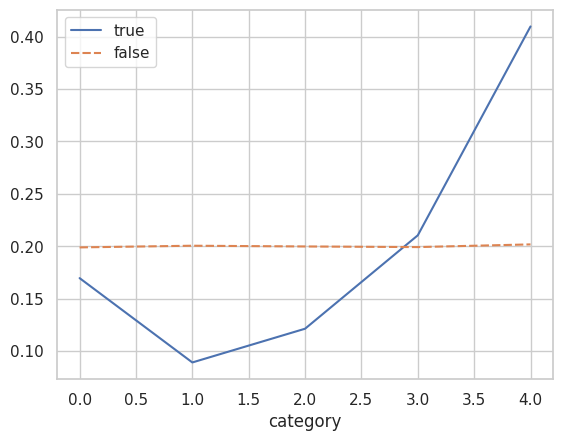

In [10]:
y = "is_apartment"
statist = pd.DataFrame()
statist['true'] = df[x][df[y] == 'true'].value_counts()
statist['true'] /= len(df[x][df[y] == 'true'])
statist['false'] = df[x][df[y] == 'false'].value_counts()
statist['false'] /= len(df[x][df[y] == 'false'])
sns.lineplot(statist)

plt.savefig(os.path.join(ASSETS_DIR,'is_apartment_influence'))



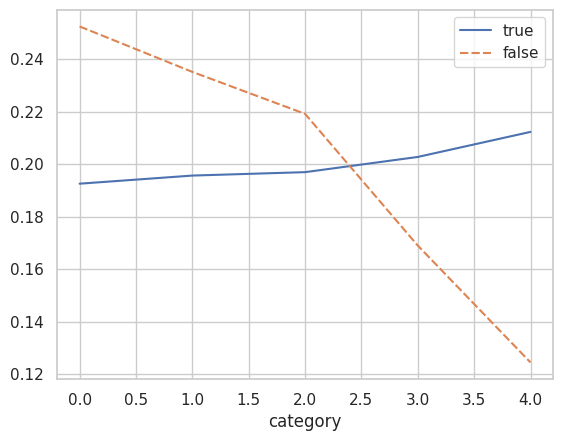

In [11]:
y = "has_elevator"
statist = pd.DataFrame()
statist['true'] = df[x][df[y] == 'true'].value_counts()
statist['true'] /= len(df[x][df[y] == 'true'])
statist['false'] = df[x][df[y] == 'false'].value_counts()
statist['false'] /= len(df[x][df[y] == 'false'])
sns.lineplot(statist)

plt.savefig(os.path.join(ASSETS_DIR,'has_elevator_influence'))



Выводы по EDA:
1. Количество комнат имеет значительное влияние на формирование цены
2. Жилая площадь имеет значительное влияние на формирование цены
3. Площадь кухни, этаж, количество этажей, количество квартир имеют влияние на формирование цен, но уже сильно меньшее.
4. Высота потолков, год постройки практически не влияют на формирование цены
5. Есть ли лифт и является ли жилье апартаментами имеет влияние на формирование цены.
6. В выборке очень неравномерное распределение значений бинарных признаков. В датасете совсем нет студий

In [12]:
import mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(tracking_uri)

In [13]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
RUN_NAME = 'eda'

In [18]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)
    mlflow.log_artifact("../EDA.ipynb")

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)
num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

Previous model fit:

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import json

preprocessor = ColumnTransformer(
    [
        ('num_cols_norm', StandardScaler(), num_columns),
        ('cat_cols_encode', OneHotEncoder(drop='if_binary'), cat_columns)
    ]
)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
metric = {}
mae = mean_absolute_error(y_test, prediction)
metric['mae'] = mae
with open('metrics.json', 'w') as f:
    json.dump(metric, f)

MAE before feature extracting:

In [21]:
metric

{'mae': 2889876.1922588153}

Feature extracting step 1:

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first')
encoder_spl = SplineTransformer(n_knots=3, degree=4)
encoder_q = QuantileTransformer(n_quantiles=100)
encoder_rb = RobustScaler()
encoder_pol = PolynomialFeatures(degree=3)
encoder_kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None)

transformer = ColumnTransformer(
  transformers=[
      ('encoder', encoder_oh, cat_columns),
      ('spl', encoder_spl, num_columns), 
      ('q', encoder_q, num_columns), 
      ('rb', encoder_rb, num_columns), 
      ('pol', encoder_pol, num_columns), 
      ('kbd', encoder_kbd, num_columns)
  ], n_jobs=-1
)


In [24]:
pipeline_fe = Pipeline(
    [
        ('preprocessor', transformer),
        ('model', model)
    ]
)
pipeline_fe.fit(X_train, y_train)
prediction_fe = pipeline_fe.predict(X_test)
metric_fe = {}
mae = mean_absolute_error(y_test, prediction_fe)
metric_fe['mae'] = mae

MAE after feature extracting:

In [25]:
metric_fe

{'mae': 2815219.1752244765}

Feature extracting Step 2 (autofeat):

In [26]:
from autofeat import AutoFeatRegressor
autofeat = AutoFeatRegressor(feateng_steps=2, max_gb=16, transformations=['1+', 'sqrt', 'abs'])

In [27]:
autofeat_tr = ColumnTransformer(
    transformers=[
        ("autofeat", autofeat, num_columns)
    ]
)

In [28]:
X_train_features = transformer.fit_transform(X_train, y_train)
new_X_train = autofeat_tr.fit_transform(X_train, y_train)
model.fit(new_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
X_test_features = transformer.transform(X_test)
new_X_test = autofeat_tr.transform(X_test)
prediction_fe_af = model.predict(new_X_test)

In [30]:

metric_fe_af = {}
mae = mean_absolute_error(y_test, prediction_fe_af)
metric_fe_af['mae'] = mae

MAE after step 2 of feature extracting:

In [31]:
metric_fe_af

{'mae': 2788845.621523655}

Comparing results before feature extracting, with feature extracting step1 and feature extracting step 2(autofeat)

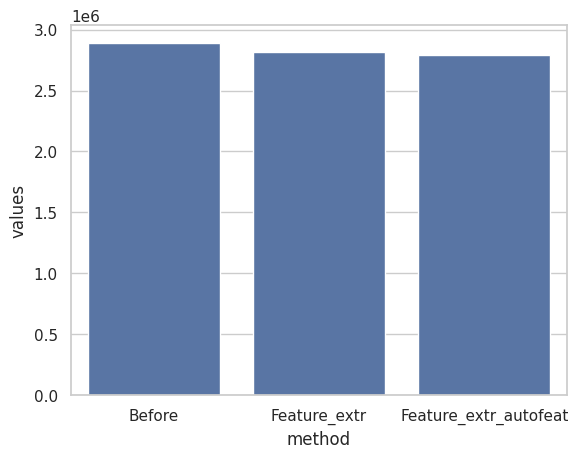

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

ASSETS_DIR = '../assets'
os.makedirs(ASSETS_DIR, exist_ok=True)

data = pd.DataFrame({
    'method': ['Before', 'Feature_extr', 'Feature_extr_autofeat'],
    'values': [metric['mae'], metric_fe['mae'], metric_fe_af['mae']]
})
sns.barplot(x='method', y='values',data=data)
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement_extracting'))

As we can see on grafics - feature extracting gives us some improvement and additional autofeat step gives us even better result. Let's calculate these improvements:

Feature extracting step 1 improvement: 

In [36]:
(metric['mae'] - metric_fe['mae'])/metric['mae']

0.025833984595715356

Feature extracting step 2 (autofeat) improvement: 

In [37]:
(metric['mae'] - metric_fe_af['mae'])/metric['mae']

0.0349601726903711

Let's save the best model (with 2 steps of feature extracting )

In [15]:
import mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(tracking_uri)

In [16]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
REGISTRY_MODEL_NAME = "better_model_aleksandra"
RUN_NAME = 'save_better_model'

In [17]:

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(new_X_test, prediction_fe_af)
input_example = new_X_test[:10]
metadata = {'model_type': 'monthly'}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metric_fe_af)
    mlflow.log_artifact(ASSETS_DIR)
    


2025-01-16 10:47:58,620 INFO: Found credentials in environment variables.
Registered model 'better_model_aleksandra' already exists. Creating a new version of this model...
2025/01/16 10:47:59 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: better_model_aleksandra, version 7
Created version '7' of model 'better_model_aleksandra'.


Now Let's make some feature selection

In [48]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

estimator = xgb.XGBRegressor(n_estimators=100, random_state=42)
sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)
sbs = SFS(estimator, k_features=10, forward=False, floating=False, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)

sfs = sfs.fit(new_X_train, y_train)
sbs = sbs.fit(new_X_train, y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

In [58]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 


sfs_df.to_csv(f"{ASSETS_DIR}/sfs.csv")
sbs_df.to_csv(f"{ASSETS_DIR}/sbs.csv") 

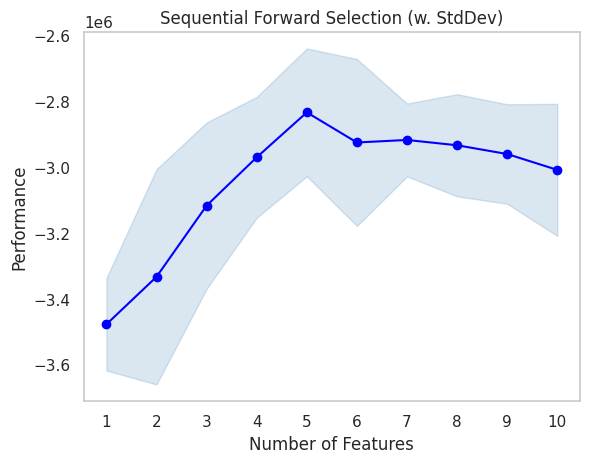

<Figure size 640x480 with 0 Axes>

In [59]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{ASSETS_DIR}/sfs.png") 

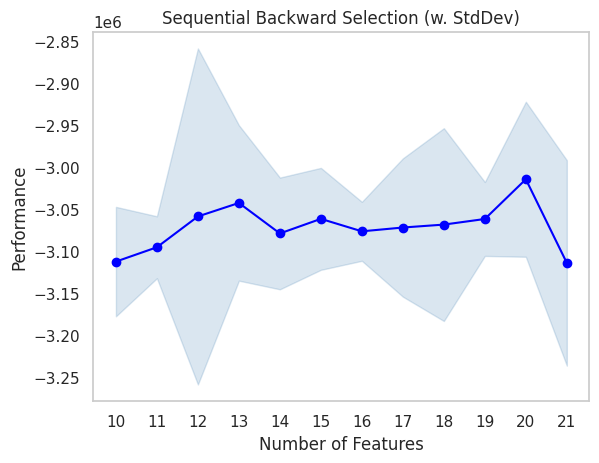

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{ASSETS_DIR}/sbs.png") 

In [61]:
sfs_features = [int(el) for el in list(top_sfs)]
sbs_features = [int(el) for el in list(top_sbs)]
interc_features = list(set(sfs_features) & set(sbs_features))
union_features = list(set(sfs_features) | set(sbs_features))

In [62]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, sfs_features], y_train)
prediction_sfs = model.predict(new_X_test[:, sfs_features])
metric_sfs = {}
mae = mean_absolute_error(y_test, prediction_sfs)
metric_sfs['mae'] = mae

In [63]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, sbs_features], y_train)
prediction_sbs = model.predict(new_X_test[:, sbs_features])
metric_sbs = {}
mae = mean_absolute_error(y_test, prediction_sbs)
metric_sbs['mae'] = mae

In [64]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, union_features], y_train)
prediction_union = model.predict(new_X_test[:, union_features])
metric_union = {}
mae = mean_absolute_error(y_test, prediction_union)
metric_union['mae'] = mae

In [65]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, interc_features], y_train)
prediction_interc = model.predict(new_X_test[:, interc_features])
metric_interc = {}
mae = mean_absolute_error(y_test, prediction_interc)
metric_interc['mae'] = mae

And now Let's compare the results

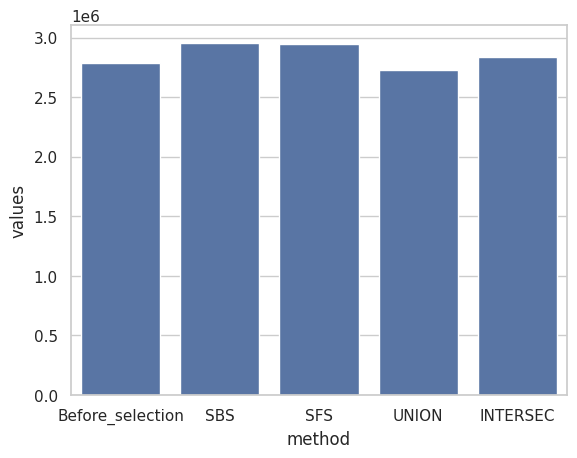

In [66]:
data = pd.DataFrame({
    'method': ['Before_selection','SBS', 'SFS', 'UNION', 'INTERSEC'],
    'values': [metric_fe_af['mae'],metric_sbs['mae'], metric_sfs['mae'], metric_union['mae'], metric_interc['mae']]
})
sns.barplot(x='method', y='values',data=data)
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement_selection'))

We have compared mae with data before feature selection and with 4 ways of feature selection: sbs, sfs, their union and thei intersec. The best resluts give us union of sbs and sfs features. 

UNION improves mae on 2 %:

In [68]:
(metric_fe_af['mae'] - metric_union['mae'])/metric_fe_af['mae']

0.021174336411509648

Lets save this model

In [69]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, union_features], y_train)
prediction_union = model.predict(new_X_test[:, union_features])
metric_union = {}
mae = mean_absolute_error(y_test, prediction_union)
metric_union['mae'] = mae

In [70]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
REGISTRY_MODEL_NAME = "selection_model_aleksandra"
RUN_NAME = 'save_selection_model'

In [71]:

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(new_X_test[:, union_features], prediction_union)
input_example = new_X_test[:10, union_features]
metadata = {'model_type': 'monthly'}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metric_union)
    mlflow.log_artifact(ASSETS_DIR)
    


Registered model 'selection_model_aleksandra' already exists. Creating a new version of this model...
2025/01/19 15:34:10 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: selection_model_aleksandra, version 5
Created version '5' of model 'selection_model_aleksandra'.


Now we take new features of the best model and make new X_train and X_test

In [74]:
X_train = pd.DataFrame(new_X_train[:, union_features])
X_test = pd.DataFrame(new_X_test[:, union_features])

Now is time to choose gyperparameters

1 way - using optuna:

In [75]:
import optuna
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from statistics import median
import numpy as np

def objective(trial: optuna.Trial) -> float:
    param = {
        "n_estimators": trial.suggest_int('n_estimatores', 50, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_seed": 0,
     }
    model = xgb.XGBRegressor(**param)

    skf = StratifiedKFold(n_splits=2)

    metric_optuna = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]
        model.fit(train_x, train_y)
        prediction = model.predict(val_x)
        mae = mean_absolute_error(val_y, prediction)
        metric_optuna["mae"].append(mae)

    # ваш код здесь #
    mae = median(np.array(metric_optuna["mae"]))
    
    return mae

In [76]:
from optuna.integration.mlflow import MLflowCallback

RUN_NAME = 'optuna_implemenation'
STUDY_NAME = 'project-2-sprint'
STUDY_DB_NAME = "sqlite:///local.study.db"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="MAE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {'mlflow.parentRunId': run_id}}
)


study = optuna.create_study(direction='minimize', study_name=STUDY_NAME,
                            storage=STUDY_DB_NAME, sampler=optuna.samplers.TPESampler(),
                            load_if_exists=True)
study.optimize(objective, n_trials=10, callbacks=[mlflc])
best_params = study.best_params

print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")

/tmp/ipykernel_1880/3812728619.py:17: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2025-01-19 15:40:50,551] Using an existing study with name 'project-2-sprint' instead of creating a new one.


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle_project_sprint_2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle_project_sprint_2/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle_project_sprint_2/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:40:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-19 15:40:53,347] Trial 19 finished with value: 3627130.284737345 and parameters: {'n_estimatores': 153, 'learning_rate': 0.08640894942332553, 'max_depth': 7, 'min_child_weight'

Number of finished trials: 29
Best params: {'n_estimatores': 93, 'learning_rate': 0.027940859846030643, 'max_depth': 12, 'min_child_weight': 1}


Calculate mae and save model

In [77]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
metric_optuna = {}
prediction = model.predict(X_test)
mae = mean_absolute_error(y_test, prediction)
metric_optuna['mae'] = mae

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]
metadata = {'model_type': 'monthly'}

REGISTRY_MODEL_NAME = 'optuna_model'

mlflow.end_run()
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id, run_id=run_id) as run:
    
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metric_optuna)
    

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle_project_sprint_2/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:42:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimatores" } are not used.

  warnings.warn(smsg, UserWarning)
Registered model 'optuna_model' already exists. Creating a new version of this model...
2025/01/19 15:42:31 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: optuna_model, version 2
Created version '2' of model 'optuna_model'.


2 way of choosing gyperparameters - RandomizeSearch:

In [78]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 5]
}

model = xgb.XGBRegressor(**params)

cv = RandomizedSearchCV(n_iter=20, estimator=model, param_distributions=params, cv=2, random_state=42, n_jobs=-1)

clf = cv.fit(X_train, y_train)

cv_results = pd.DataFrame(clf.cv_results_)

best_params = clf.best_params_

Calculate mae and save model

In [79]:
model = xgb.XGBRegressor(**best_params)


model.fit(X_train, y_train)
prediction = model.predict(X_test)

metric_randomCV = {}
mae = mean_absolute_error(y_test, prediction)
metric_randomCV['mae'] = mae


# дополнительные метрики из результатов кросс-валидации
metric_randomCV['mean_test_score'] = cv_results['mean_test_score'].mean()# среднее время обучения
metric_randomCV['std_fit_time'] = cv_results['std_fit_time'].mean()# стандартное отклонение времени обучения
metric_randomCV['mean_fit_time'] = cv_results['mean_fit_time'].mean() # средний результат на тесте
metric_randomCV['std_test_score'] = cv_results['std_test_score'].mean()# стандартное отклонение результата на тесте
metric_randomCV['best_score'] = clf.best_score_

# настройки для логирования в MLFlow
pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]

RUN_NAME = 'model_random_search_project'
REGISTRY_MODEL_NAME = "random_search_model_project"

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    cv_info = mlflow.sklearn.log_model(
        cv, artifact_path='cv')
    model_info = mlflow.catboost.log_model(
        cb_model = model,
        artifact_path='models',
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements)
    mlflow.log_params(best_params)
    mlflow.log_metrics(metric_randomCV)

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle_project_sprint_2/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:43:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
Registered model 'random_search_model_project' already exists. Creating a new version of this model...
2025/01/19 15:43:54 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: random_search_model_project, version 2
Created version '2' of model 'random_search_model_project'.


Compare results:

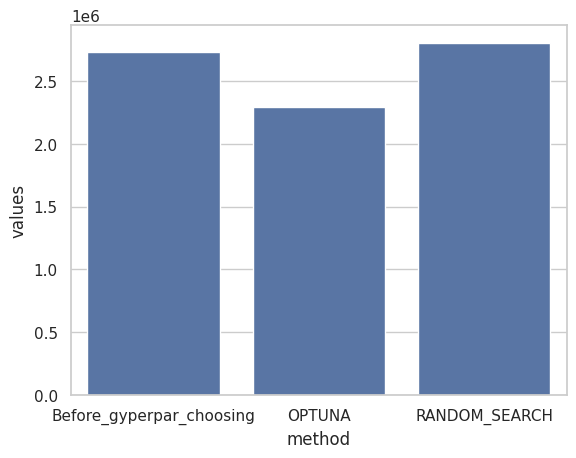

In [81]:
data = pd.DataFrame({
    'method': ['Before_gyperpar_choosing',
                'OPTUNA', "RANDOM_SEARCH"],
    'values': [metric_union['mae'], metric_optuna['mae'],
                metric_randomCV['mae']]
})
sns.barplot(x='method', y='values',data=data)
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement_gyperpar_plot'))

We have compared results beforen choosing gyperparameters and after it in 2 ways - using optuna and using Randomizedsearch. Random search give even worse result than before choosing gyperparameters. Optuna gives us significant improvement:


In [82]:
(metric_union['mae'] - metric_optuna['mae'])/metric_union['mae']

0.15930098025718029

All improvement of model:

In [83]:
(metric['mae'] - metric_optuna['mae'])/metric['mae']

0.2058708724732569

20% sounds like very significat improvement